# Magnification distribution in weak and strong lensing

This notebooks comptues the magnification distribution including both weak and strong lensing, for later use in calibrating $p(\mu|z<0.7)$

Author: Jose Maria Ezquiaga

In [1]:
#-- DEFINITIONS --
import numpy as np

from scipy.integrate import quad, trapezoid
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d

#from constants import *
import time

import astropy.units as astrou
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value

#PLOTTING MODULES
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSZ = 17
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

import sys
dir_base=sys.path[0]
dir_out="/Users/jmezquiaga/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Research/gws/lensing_gw/lensing_outliers/plots_magnification_distribution"

In [2]:
H0 = cosmo.H(0).value
Om = cosmo.Om(0)
h0 = cosmo.H(0).value/100
Ob = cosmo.Ob(0)
Ocdm = Om - Ob

## Weak lensing

To compute the magnification distribution in weak lensing we follow [Takahashi et al. (2012)](https://arxiv.org/pdf/1106.3823). This method is also used by [Oguri (2018)](https://arxiv.org/pdf/1807.02584). 

The method models the converge distribution with a modified lognormal distribution, which depends on three parameters. These parameters solely depends on the variance of the convergence $\langle \kappa^2\rangle$ and the convergence in an empty Universe. They can be fixed by imposing the normalization condition and the mean convergence.

To model the (non-linear) matter power spectrum we use  [class](http://class-code.net/).

The magnification and convergence are related by the following equation:

In [5]:
def mu_kappa(kappa):
    return 1./(1-kappa)**2

Convergence PDF

$$\frac{dP}{d\kappa} = N_\kappa \exp\left[ -\frac{1}{2\omega_\kappa^2} \left( \ln\left(1 + \frac{\kappa}{|\kappa_{\text{empty}}|} \right) + \frac{\omega_\kappa^2}{2} \right)^2 \cdot \left(1 + \frac{A_\kappa}{1 + \kappa / |\kappa_{\text{empty}}|} \right)\right] \frac{1}{\kappa + |\kappa_{\text{empty}}|}$$

In [6]:
def dP_dkappa(kappa, N_kappa, omega2_kappa, A_kappa, kappa_empt):
    """
    Compute the convergence PDF dP/dkappa as defined in Equation (2) of arXiv:1807.02584.

    Parameters:
    - kappa: float or np.ndarray, the convergence value(s)
    - N_kappa: normalization constant
    - omega_kappa: width parameter
    - A_kappa: amplitude parameter
    - kappa_empty: minimum convergence (negative value)

    Returns:
    - dP_dkappa: float or np.ndarray, the value(s) of the PDF at kappa
    """
    # Ensure kappa_empty is positive for absolute value
    abs_kappa_empty = abs(kappa_empt)

    # Compute the logarithmic term
    log_term = np.log(1 + kappa / abs_kappa_empty + 1e-20)  # Adding a small constant to avoid log(0)
    exponent = -0.5 / (omega2_kappa) * (log_term + 0.5*omega2_kappa)**2

    # Compute the correction factor
    correction = 1. + A_kappa / (1 + kappa / abs_kappa_empty + 1e-20)

    # Compute the exponential part
    exp_part = np.exp(exponent* correction)

    # Compute the denominator
    denominator = kappa + abs_kappa_empty + 1e-20  # Adding a small constant to avoid division by zero

    # Final PDF
    dP_dkappa = N_kappa * exp_part / denominator

    return dP_dkappa

Convergence of an empty universe

$$\kappa_{\text{empty}} = -\frac{3\Omega_M}{2} \left( \frac{H_0}{c} \right)^2 \int_0^{z_s} \frac{cdz}{H(z)} (1+z) \frac{r(\chi) r(\chi_s - \chi)}{r(\chi_s)}$$

In [7]:
from scipy.integrate import quad
from scipy.constants import c


def kappa_empty(z_s, Omega_M=Om, H0=H0):
    """
    Compute the minimum convergence kappa_empty for a source at redshift z_s.

    Parameters:
    - z_s: Source redshift
    - Omega_M: Matter density parameter
    - H0: Hubble constant in km/s/Mpc

    Returns:
    - kappa_empty: Minimum convergence value
    """
    c_km = c / 1e3  # Speed of light in m/s

    # Comoving distance to source
    chi_s = cosmo.comoving_distance(z_s).value  # in Mpc

    def integrand(z):
        chi = cosmo.comoving_distance(z).value  # in Mpc
        dchi_dz = c_km / cosmo.H(z).value  # in Mpc
        r = chi
        r_s = chi_s
        return dchi_dz * (1 + z) * (r * (r_s - r) / r_s) 

    integral, _ = quad(integrand, 0, z_s)

    prefactor = -1.5 * Omega_M * (H0 / c_km)**2
    return prefactor * integral

Variance of the convergence

$$\langle \kappa^2 \rangle = \frac{9 \Omega_M^2}{8\pi} \left( \frac{H_0}{c} \right)^4 \int_0^{z_s} \frac{cdz}{H(z)} (1+z)^2 \left( \frac{r(\chi) r(\chi_s - \chi)}{r(\chi_s)} \right)^2 \int dk\, k P_m(k, z)$$

In [28]:
def dP_dmu_wl(mu, N_kappa, omega2_kappa, A_kappa,kappa_empty_val, mu0=3.0):
    """
    Compute dP/dmu from dP/dkappa using Equation (8) and apply truncation from Equation (9).

    Parameters:
    - mu: float or np.ndarray, magnification values
    - dP_dkappa_func: function, takes kappa and returns dP/dkappa
    - mu0: float, cutoff magnification for exponential truncation (default: 3.0)

    Returns:
    - dP_dmu: float or np.ndarray, magnification PDF values
    """
    mu = np.asarray(mu)
    valid = mu > 0
    dP_mu = np.zeros_like(mu)

    # Compute kappa from mu
    kappa = 1 - 1 / np.sqrt(mu[valid]) 
    dP_kappa = dP_dkappa(kappa,N_kappa, omega2_kappa, A_kappa,kappa_empty_val)

    # Equation (8)
    dP_mu[valid] = ((1 - kappa)**3 / (2)) * dP_kappa

    # Equation (9): apply exponential cutoff
    dP_mu[valid] *= np.exp(-(mu[valid] / mu0)**4)

    return dP_mu

## Weak lensing: from data

Only need to load the functions `mu_kappa`, `kappa_empty`, `dP_dkappa`, and `dP_dmu`

In [10]:
#Read the parameters N_kappa, omega2_kappa, A_kappa from the file
data = np.loadtxt('fitting_kappa_distribution.txt', skiprows=1)
zSs = data[:,0]
N_kappa_sols = data[:,1]
omega2_kappa_sols = data[:,2]
A_kappa_sols = data[:,3]

#Interpolate the parameters
N_kappa_interp = interp1d(zSs, N_kappa_sols)
omega2_kappa_interp = interp1d(zSs, omega2_kappa_sols)
A_kappa_interp = interp1d(zSs, A_kappa_sols)



/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_11718/2322429758.py:19: RuntimeWarning: invalid value encountered in log
  log_term = np.log(1 + kappa / abs_kappa_empty + 1e-20)  # Adding a small constant to avoid log(0)


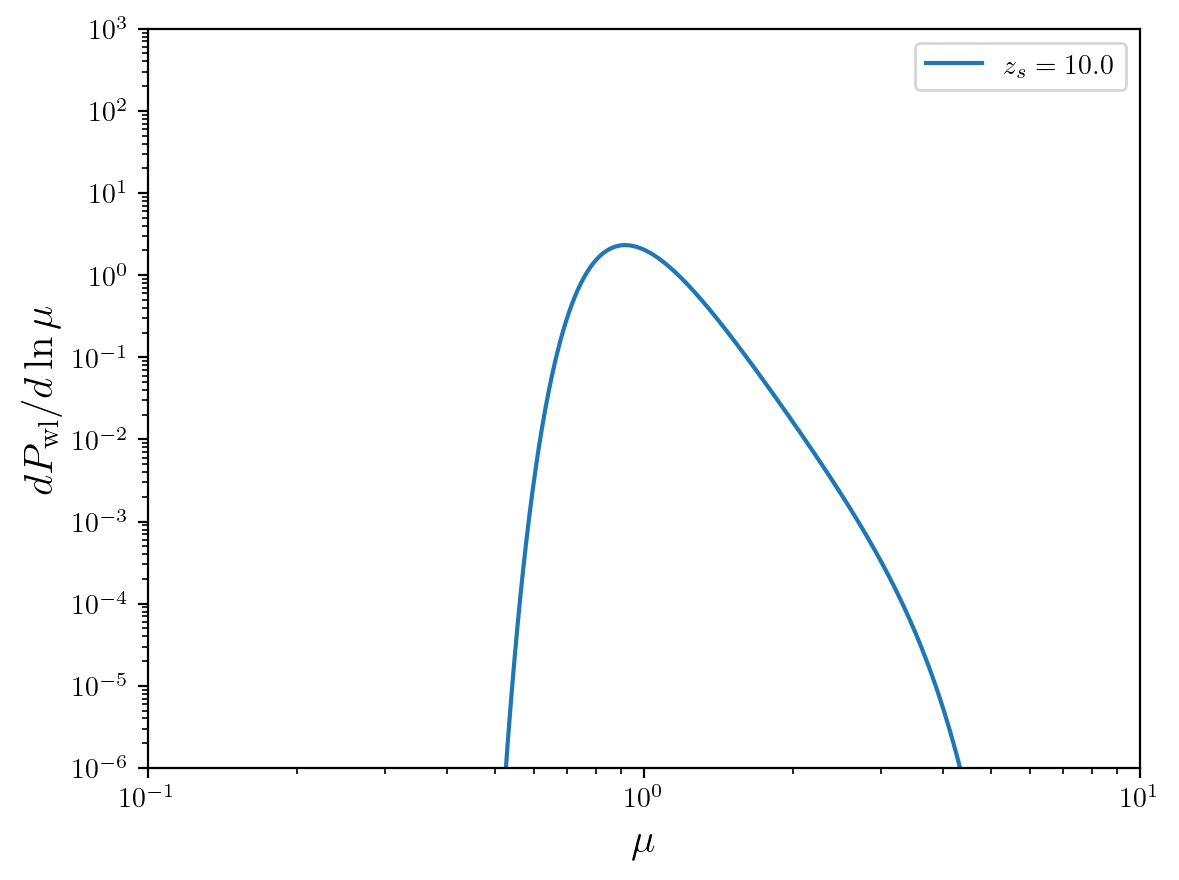

In [85]:
zS = 10.

#Values from interpolation
N_kappa_zS = N_kappa_interp(zS)
omega2_kappa_zS = omega2_kappa_interp(zS)
A_kappa_zS = A_kappa_interp(zS)

kappa_empty_zS = kappa_empty(zS)
mu_min = mu_kappa(kappa_empty_zS)
mu_max = 5.
nmus = 10000
mus = np.linspace(mu_min, mu_max, nmus)
dPdlnmu = mus * dP_dmu_wl(mus, N_kappa_zS, omega2_kappa_zS, A_kappa_zS,kappa_empty_zS, mu0=3.0)
plt.loglog(mus,dPdlnmu, label=r'$z_s=%s$' % zS)
plt.xlim(0.1, 10)
plt.ylim(1e-6, 1000)
plt.xlabel(r'$\mu$', fontsize=fontSz)
plt.ylabel(r'$dP_\mathrm{wl}/d\ln\mu$', fontsize=fontSz)
plt.legend()
plt.show()

# Strong lensing

We compute the optical depth for a SIS universe where lenses are galaxies that follow a Schecter profile

In [20]:
Clight = 299792458.       # speed of light (m/s)
#SIS with Schechter Mass Function
def dtau_Schechterdz(zS,zL,n,sigmaS,alpha,beta):
    #sigmaS km/s
    #n in #/Mpc^3
    c_km = Clight/1000
    Hz = cosmo.H(zL).value #Km/Mpc /s
    DL = cosmo.angular_diameter_distance(zL).value #Mpc
    DS = cosmo.angular_diameter_distance(zS).value #Mpc
    DLS = cosmo.angular_diameter_distance_z1z2(zL,zS).value #Mpc
    
    factor = 16 * np.power(np.pi,3)
    
    return factor*np.power(1+zL,2)*(c_km*n/Hz)*np.power(DL*DLS/DS,2)*np.power(sigmaS/c_km,4)*gamma((4+alpha)/beta)/gamma(alpha/beta)
    
def tau_Schechter(zS,n,sigmaS,alpha,beta,zLmin=0.001):
    zLs = np.logspace(np.log10(zLmin),np.log10(zS),100)
    return trapezoid(dtau_Schechterdz(zS,zLs[:-1],n,sigmaS,alpha,beta),zLs[:-1])
tau_Schechter = np.vectorize(tau_Schechter)

In [21]:
from scipy.interpolate import interp1d
n = 8e-3 * np.power(H0/100,3) #Mpc^-3
sigmaS,alpha,beta = 161, 2.32, 2.67

zs = np.linspace(0.02,30,1000)
tau_int = interp1d(zs,tau_Schechter(zs,n,sigmaS,alpha,beta),bounds_error=False,fill_value=np.nan)

We also read Oguri's optical depth

In [130]:
data_oguri = np.loadtxt('run2_oguri_optical_depth.dat')
z_oguri = data_oguri[:,0]
tau_oguri = data_oguri[:,1]

tau_oguri_interp = interp1d(z_oguri, tau_oguri, bounds_error=False, fill_value=np.nan)

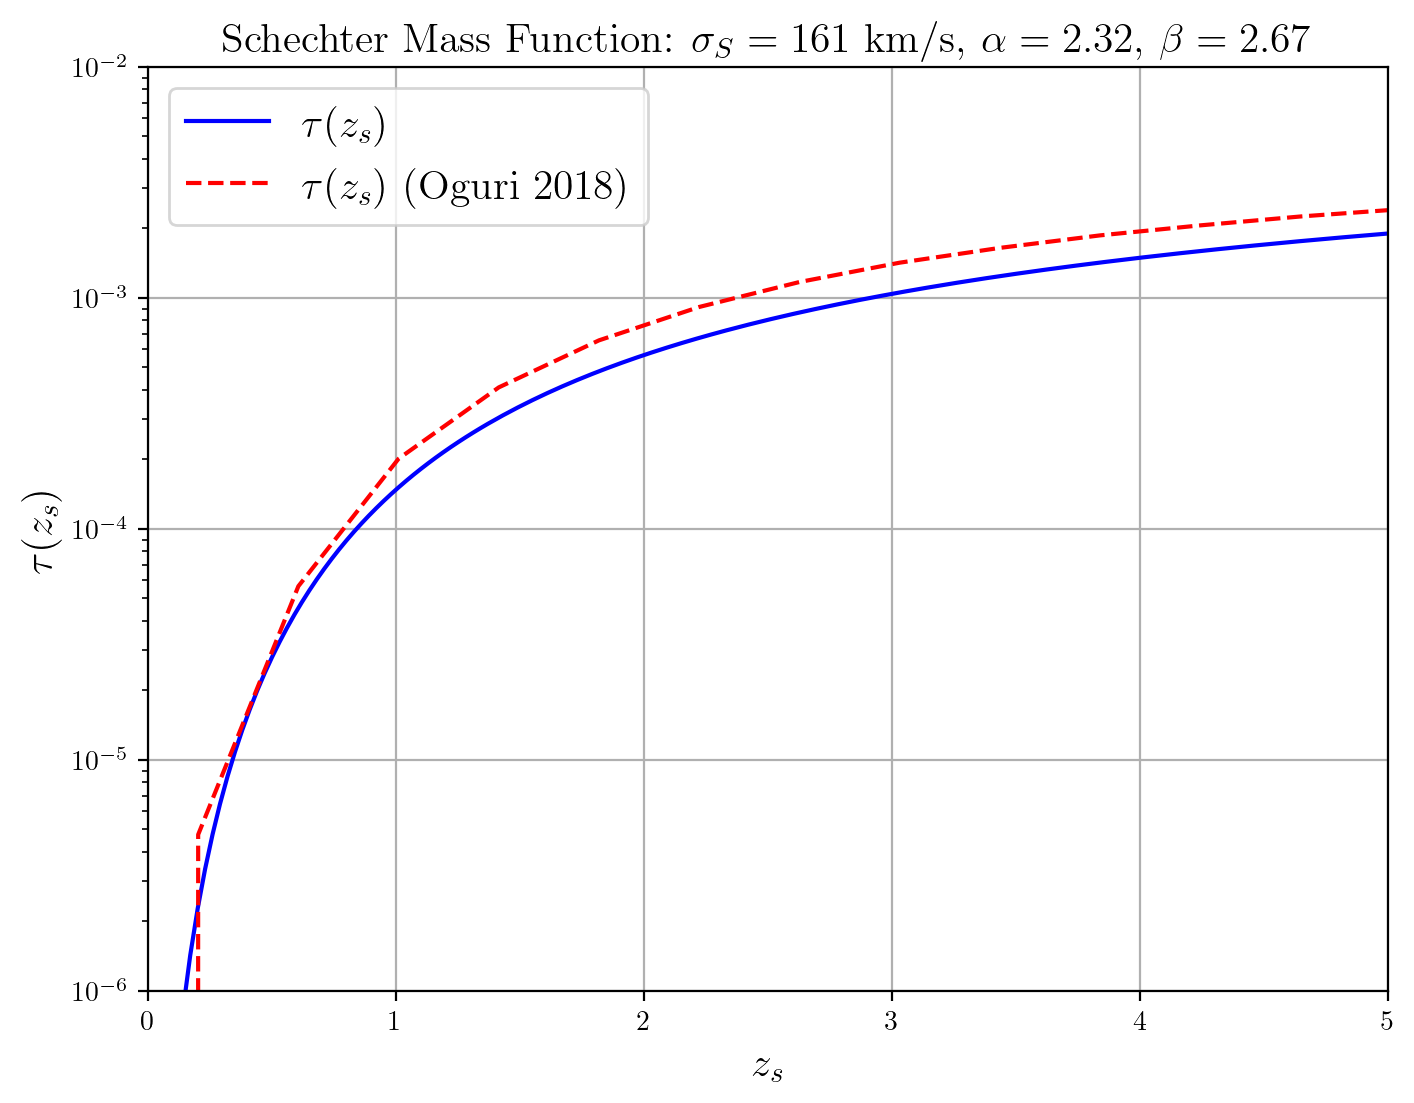

In [129]:
plt.figure(figsize=(8,6))
plt.plot(zs, tau_int(zs), label=r'$\tau(z_s)$', color='blue')
plt.plot(z_oguri, tau_oguri, label=r'$\tau(z_s)$ (Oguri 2018)', color='red', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$z_s$', fontsize=fontSz)
plt.ylabel(r'$\tau(z_s)$', fontsize=fontSz)
plt.title(r'Schechter Mass Function: $\sigma_S = %s$ km/s, $\alpha = %s$, $\beta = %s$' % (sigmaS, alpha, beta), fontsize=fontSz)
plt.legend(fontsize=fontSz)
plt.grid()
plt.xlim(0,5)
plt.ylim(1e-6,1e-2)
plt.show()

Read Oguri magnification distribution

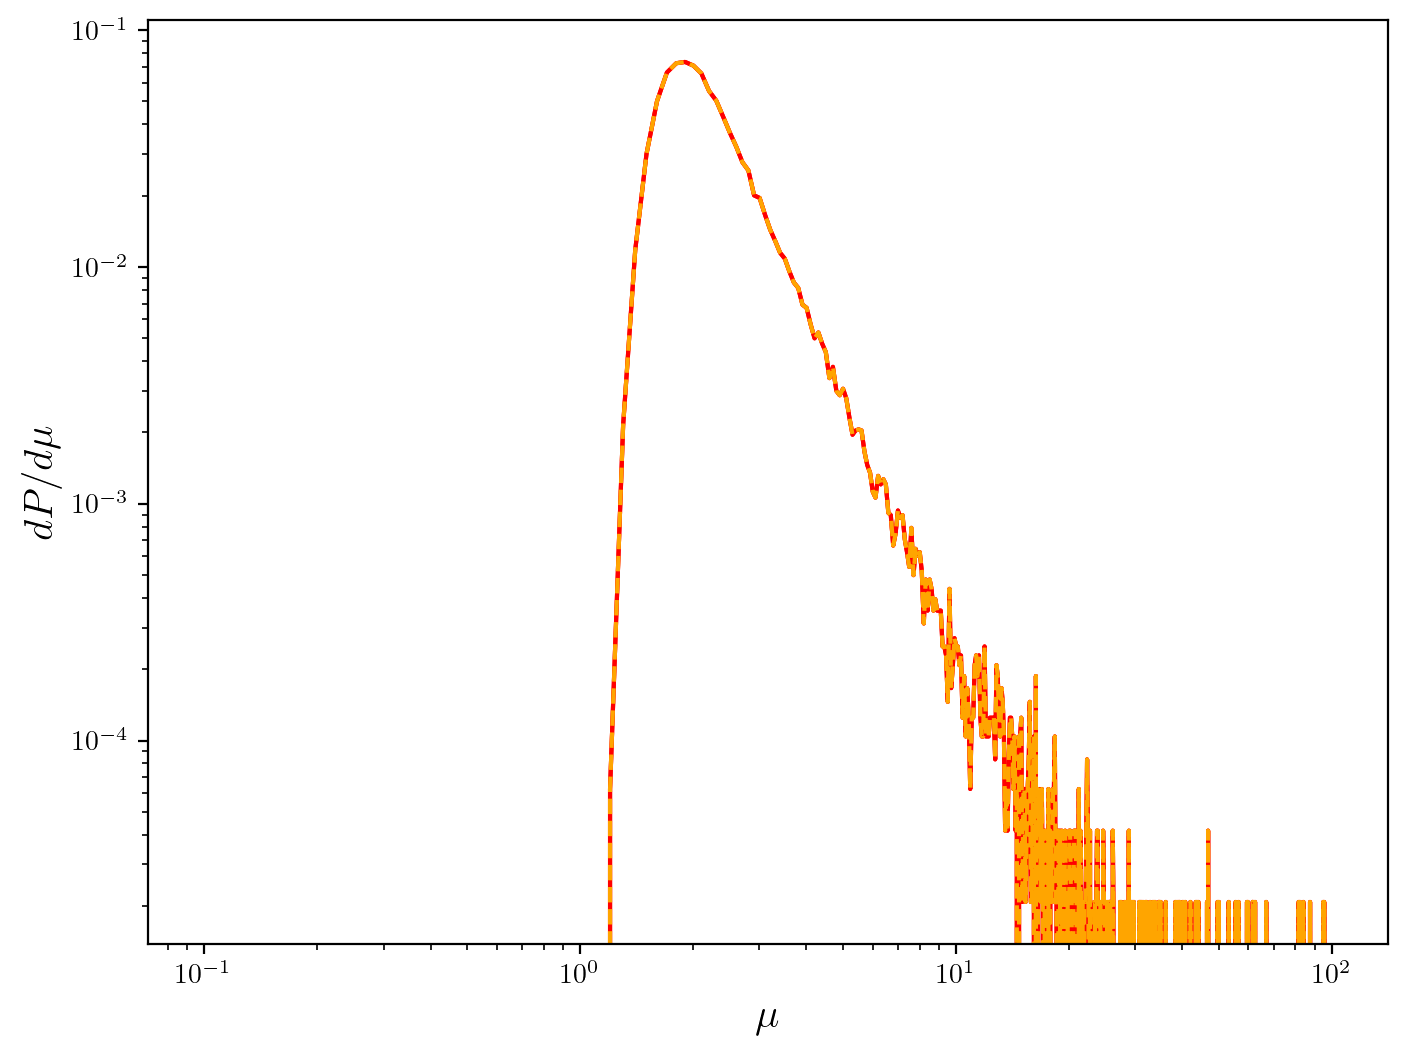

In [61]:
#Read txt file with the parameters
data = np.loadtxt('mu_hist.txt')
mus_hist = data[:,0]
dPdmu_hist = data[:,1]

dPdmu_sl_oguri = interp1d(mus_hist, dPdmu_hist, bounds_error=False, fill_value=0.0)

plt.figure(figsize=(8,6))
plt.plot(mus_hist, dPdmu_hist, label='Histogram from simulations', color='red')
plt.loglog(mus_hist, dPdmu_hist, label='Histogram from simulations', color='red')
plt.plot(mus_hist, dPdmu_sl_oguri(mus_hist), label='Interpolated Histogram', color='orange', linestyle='--')
plt.xlabel(r'$\mu$', fontsize=fontSz)
plt.ylabel(r'$dP/d\mu$', fontsize=fontSz)

plt.show()

In [131]:
def dP_dmu_sl(mu,zS):
    # 1/mu^3 for mu > mu_th
    mu = np.asarray(mu)
    dP_mu = dPdmu_sl_oguri(mu)#np.zeros_like(mu)
    mu_th = 3
    valid = mu > mu_th
    dP_mu[valid] = dPdmu_sl_oguri(mu_th)*(mu_th**3) / (mu[valid]**3)
    # Normalize the PDF
    normalization = np.trapz(dP_mu, mu)
    dP_mu /= normalization
    return dP_mu * tau_oguri_interp(zS)


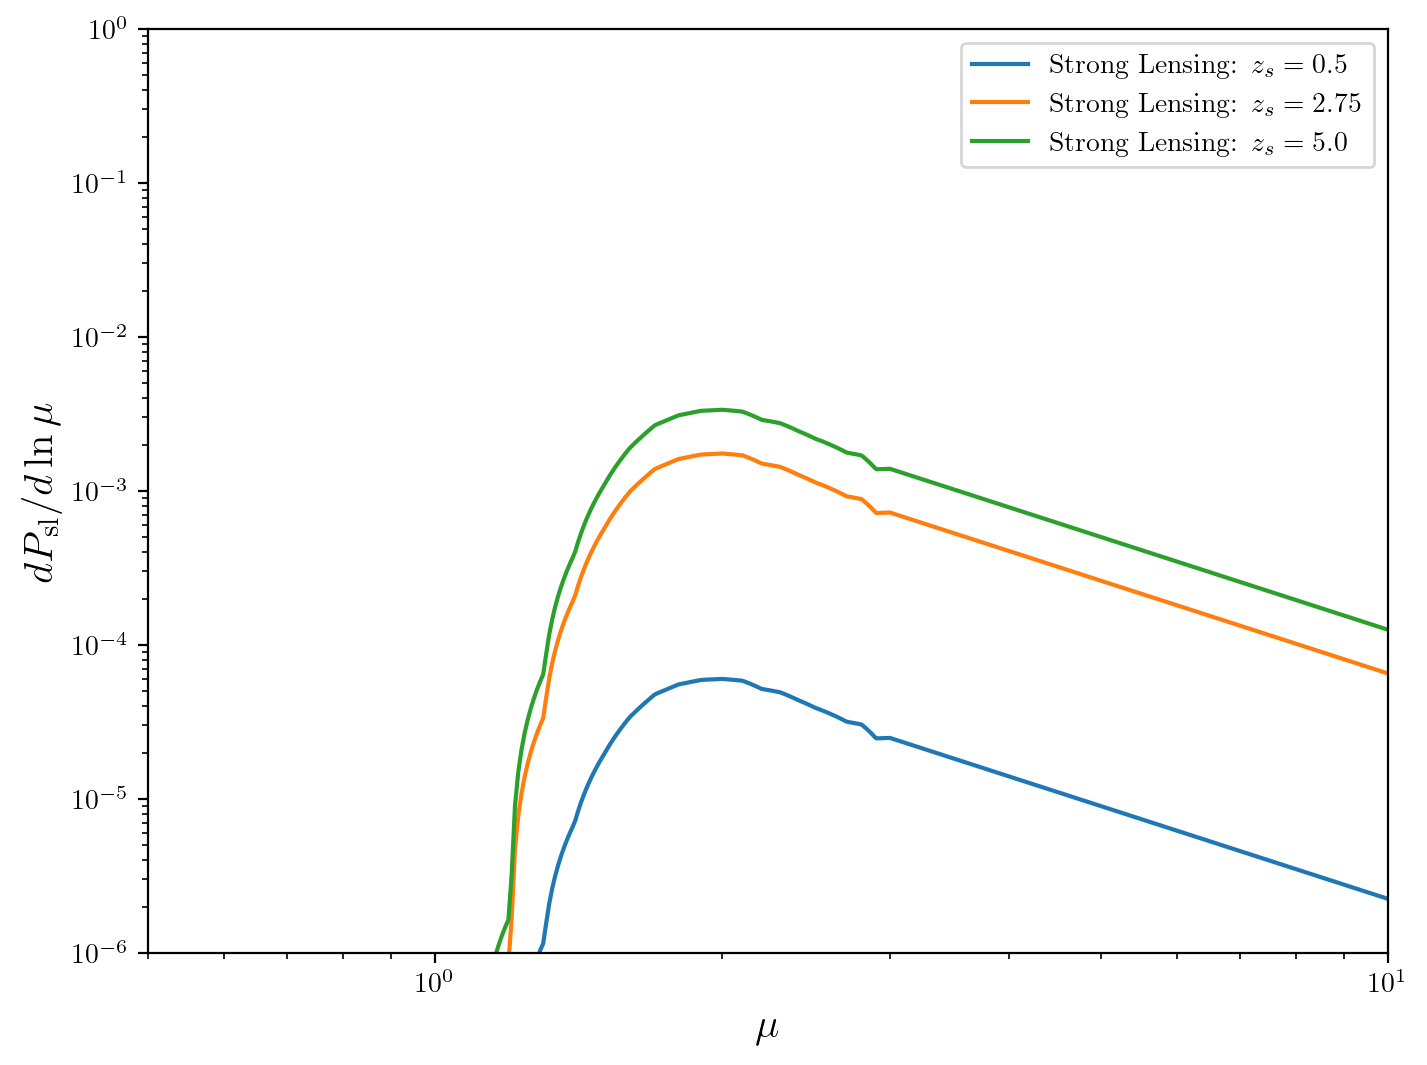

In [132]:
#Plot strong lensing magnification distribution
plt.figure(figsize=(8,6))
mu_sl = np.linspace(0.5, 10, 1000)
zSs = np.linspace(0.5,5,3)
for zS in zSs:
    dPdlnmu_sl = mu_sl * dP_dmu_sl(mu_sl, zS)
    plt.loglog(mu_sl, dPdlnmu_sl, label=r'Strong Lensing: $z_s = %s$' % zS)
plt.xlim(0.5, 10)
plt.ylim(1e-6, 1)
plt.xlabel(r'$\mu$', fontsize=fontSz)
plt.ylabel(r'$dP_\mathrm{sl}/d\ln\mu$', fontsize=fontSz)
plt.legend()
plt.show()

# WL + SL

In [133]:
def dP_dmu(mu, zS):
    """
    Combined magnification distribution from weak and strong lensing.

    Parameters:
    - mu: float or np.ndarray, magnification values
    - zS: Source redshift

    Returns:
    - dP_mu: float or np.ndarray, combined magnification PDF values
    """
    N_kappa_zS = N_kappa_interp(zS)
    omega2_kappa_zS = omega2_kappa_interp(zS)
    A_kappa_zS = A_kappa_interp(zS)
    kappa_empty_zS = kappa_empty(zS)

    dPdmu_wl = dP_dmu_wl(mu, N_kappa_zS, omega2_kappa_zS, A_kappa_zS,kappa_empty_zS, mu0=3.0)
    dPdmu_sl = dP_dmu_sl(mu, zS)
    
    # Combine the two distributions
    norm = (1.-tau_oguri_interp(zS))/np.trapz(dPdmu_wl[dPdmu_wl>0], mu[dPdmu_wl>0])
    return norm*dPdmu_wl + dPdmu_sl,norm

/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_11718/2322429758.py:19: RuntimeWarning: invalid value encountered in log
  log_term = np.log(1 + kappa / abs_kappa_empty + 1e-20)  # Adding a small constant to avoid log(0)


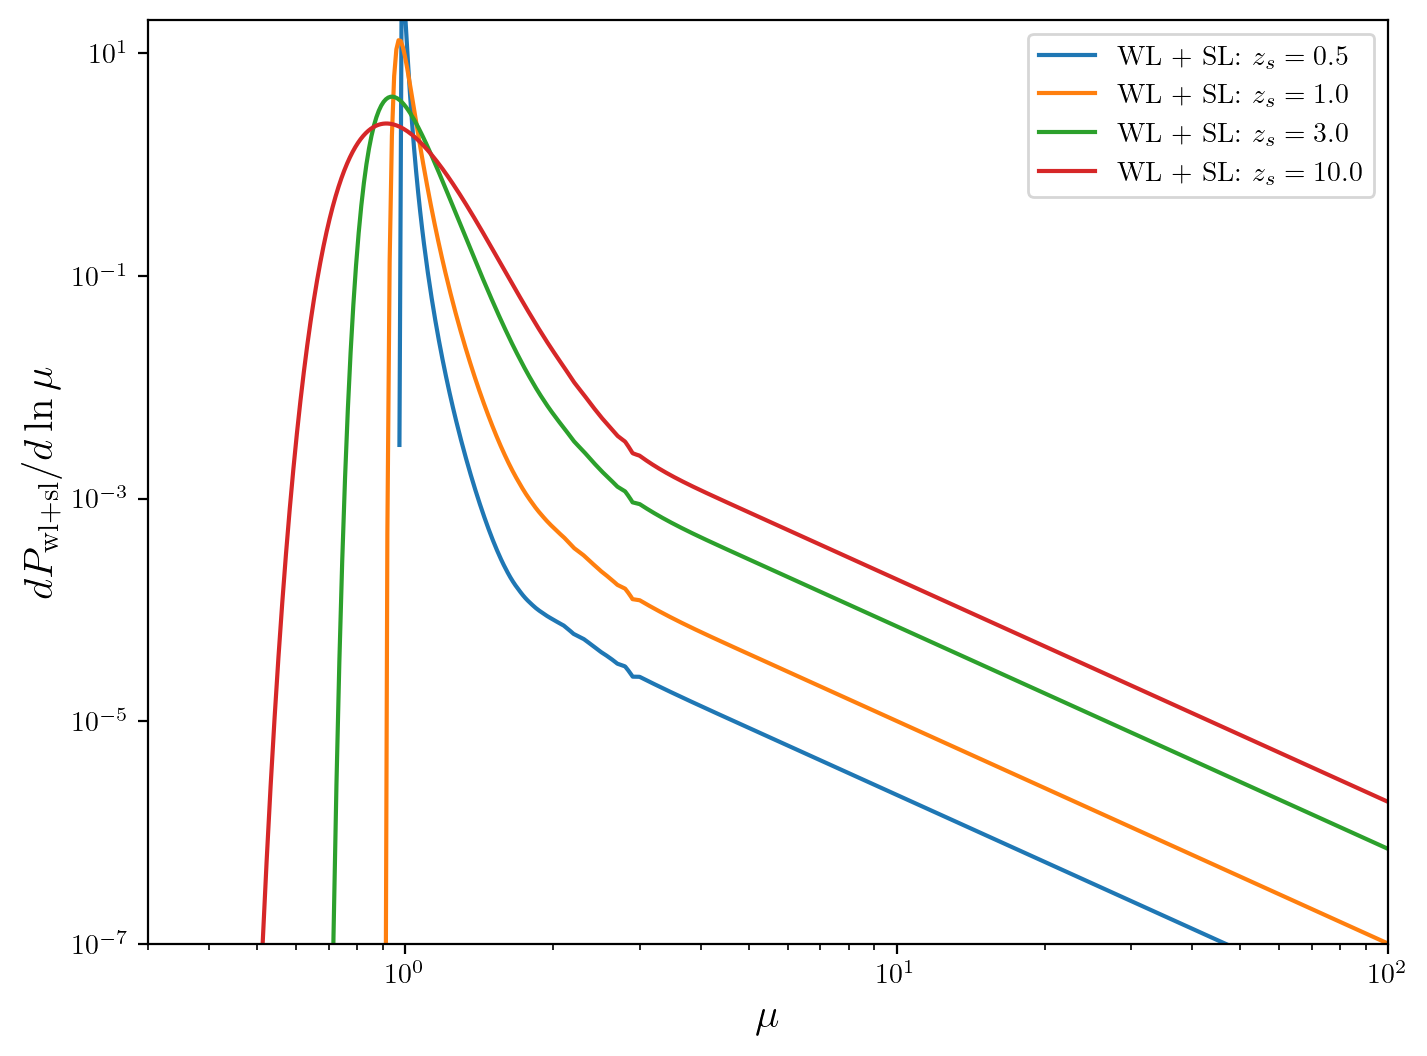

In [134]:
#Plot strong lensing magnification distribution
plt.figure(figsize=(8,6))
zSs = np.array([0.5,1.,3,10])
for zS in zSs:
    kappa_empty_zS = kappa_empty(zS)
    mu_min = mu_kappa(kappa_empty_zS)
    mu_max = 100.
    nmus = 10000
    mus = np.linspace(mu_min, mu_max, nmus)
    dPdlnmu = mus * dP_dmu(mus, zS)[0]
    norm = dP_dmu(mus, zS)[1]
    plt.loglog(mus, dPdlnmu, label=r'WL + SL: $z_s = %s$' % zS)
plt.xlim(0.3, 100)
plt.ylim(1e-7, 20)
plt.xlabel(r'$\mu$', fontsize=fontSz)
plt.ylabel(r'$dP_\mathrm{wl+sl}/d\ln\mu$', fontsize=fontSz)
plt.legend()
plt.show()